# About this Notebook

**This notebook is the first part of my notebook series to reach [lb.9508](https://www.kaggle.com/mint101/jmtc-20-lb-9508-mono-lingual-models) before blending with others result. Hope this kernel can serve as a starter notebook of this competition, and help people avoid some traps in the begining.**

# Simple Setting and Result
This simple pure XLM-R notebook uses the original training data and [multiple language translation](https://www.kaggle.com/miklgr500/jigsaw-train-multilingual-coments-google-api) of the 2018 one. It sampled the negative data to nearly the same size of the positive ones, and combined all of them into the final training data. 

The learning schedule is to train 2.5 epoch on training data (save and load best model by ModelCheckPoint) and 1 epoch on valid data, both with nearly constant learning rate (1e-5 and 8e-6, chosen heuristically).

With this simple setting, one can get lb around <span style="color:red">0.9420 - 0.9445</span> within 1h. By simple ensembling results of multiple attempts, one can get about <span style="color:red">lb.9455+</span>.

<u>(One can check version-1 for exact training logs. I do not rerun the kernal as I am lack of TPU quota)</u>

# Intro. of the task and literature (- early 2020)

Jigsaw Toxic Comment competition has been hold for three years. The first year(2018) one gives toxic and non-toxic comments, while the second year(2019) one enlarges data size and gives soft label of toxicity. For the third year, JWTC-2020 combines the training data of last two year, while try to judge toxicity cross language.

The JWTC task is a typical sentimental analysis task in the area of nature language processing(NLP). Before going deep into the task, we'd better look at the current literature of NLP. 

<br/>

The NLP area is quite different before and after 2018. Before 2018, people usually design different models for different tasks, while model consists of fixed word embedding plus RNN/CNN. After 2018, Bert-like pretrained models dominate all tasks. An additional top layer with fine-tuning is enough to transfer them to down-streaming task and get a deccent result.

**The following graph shows this development process:**

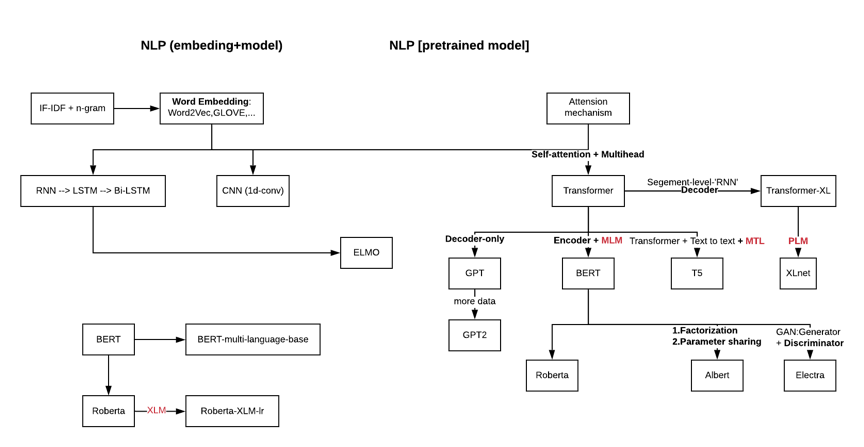

1. In the begining, people used RNN/CNN over fixed word embedding like Word2Vec.
2. In translation and text generation tasks, [Attention mechanism](https://arxiv.org/pdf/1409.0473.pdf) is found to be useful.
3. Based on Self-attention and embedded ensembling(multi-head), [Transformer](https://arxiv.org/pdf/1706.03762.pdf) is proposed and replace RNN/CNN in this field.
4. Fixed word embedding is showed unable to capture difference of the same word in varied contents. <***Hence, combining word embedding and layers atop to provide contextualized word representations become mainstream.***>
5. [ELMO](https://arxiv.org/pdf/1802.05365.pdf) is proposed first based on ***Bi-directional LSTM***.
6. [GPT](https://s3-us-west-2.amazonaws.com/openai-assets/research-covers/language-unsupervised/language_understanding_paper.pdf) is the next with ***Decoder part of Transformer***. (It uses the generative part, so only in one direction.)
7. [BERT](https://arxiv.org/pdf/1810.04805.pdf) is the last but the best one. It use ***Encoder part of Transformer and Masked language model(MLM)*** to look up context on both side from the begining.

**After Bert, there are two main directions in this field:**

**The first one is to change structure of BERT(including training pattern):**
1. [Roberta](https://arxiv.org/pdf/1907.11692.pdf):  fine tunes BERT and get better performance.
2. [XLNet](https://arxiv.org/pdf/1906.08237):  invents Transformer-XL for super long context by involving a segment-level "RNN" on Decoder, then use Permutated language model(PLM) to train a generative model with knowledge of context in both side.
3. [Albert](https://arxiv.org/pdf/1909.11942.pdf):  use word embdedding decomposition and weight sharing to save training cost and  time. With this saving, it makes BERT wider and deeper for better performance.
4. [T5](https://arxiv.org/abs/1910.10683):  unifies different tasks to the same text-to-text pattern, use multiple task learning(MTL) to achieve a new SOTA.
5. [Electra](https://arxiv.org/pdf/2003.10555.pdf):  use the concept of GAN to train BERT with generator and discriminator.


**The second one is to enlarge training corpus and include different languges:**
1. A lot of monolinguish BERT models are trained with languge other than English.
2. Cross languge model like mbert and [XLM-Roberta](https://arxiv.org/pdf/1911.02116.pdf) are trained on multiple language corpus. 


# Two ideas and Corresponding Starter Kernel

Back to JMTC-2020. One special point of the task is that the training data is in English, while valid and test data are in other languages. It is a zero-shot like task, where competition orgnizer want to see whether pure training on english can transfer to other language directly.

To solve this problem, we can either use a **pretrained cross language model**, or some kinds of **translation**. (**or both**)

1. For the first idea, the typical starter kernel is @xhlulu 's https://www.kaggle.com/xhlulu/jigsaw-tpu-xlm-roberta. (lb.9383). 

He only use the English training data, sample the negative data for label balancing, train on training data for 2 epoch and valid data for 2 epcoh. His result illustrated the importance of label balancing and ultilizing valid data in this competition.

<br/>

2. For the second one, the starter of this "translation to English" path is @miklgr500 's https://www.kaggle.com/miklgr500/jigsaw-tpu-bert-with-huggingface-and-keras (lb .9158). 

He traina BERT-base on fraction of 2018 data and elaborate on learning rate schedule. I tried his way with other advanced BERT-like model and more data, but the lb score always <.92 indicates that using translation to inference may be misleading.

In contrast, the first one seems better. To further boost its performance, people start to do different data augmentations. They find that the second idea can also be used as augmentations, so they translate the training data into target languages, then use XLM or other monolinguish models over the translations. 

<h4><u>This "use both" idea is the mainstream choice in this competition and is used in this notebook.</u><h4/>

# The trap about BERT-like model volatility

The BERT-like model are very powerful but volatile. From https://arxiv.org/pdf/2002.06305.pdf, we can find that changing random seed of weight initialization and data order alone can affect performance a lot.

Moreover, training with TPU intorduing [uncontrollable randomness](https://cloud.google.com/tpu/docs/troubleshooting#deterministic-training) in data order and parameter updating. That means the training result can vary a lot even all hyperparameters remain the same and random seed is fixed.

Combine the two facts above, we can understand that hyperparameter tuning and model structure choosing is more difficult on TPU. If one just use one-time training result to select hyperparameter and structure, it can be easily mislead by randomness.

<br/><br/>

For example, the following three kernels use similar structure and complexer setting but have smaller lb score:

1. https://www.kaggle.com/yeayates21/xlm-roberta-augmentation-ssl-0-9417-pub-lb (.9399): used extra open-subtitle dataset and additional augmentations.
2. https://www.kaggle.com/riblidezso/train-from-mlm-finetuned-xlm-roberta-large (.9422): used seperated learning rate by layers.
3. https://www.kaggle.com/shonenkov/tpu-training-super-fast-xlmroberta (.9416): used huge amount of augmented data and upsampled the positve data rather than downsampling the negative one. 

<span style="color:blue">They all add extra setting before thoroughly explore the basic one, which consumes more resource but does not give better result.</span>

<br/>

<u> I actually followed the third one and implemented upsampling with tf.data.experimental.sample_from_datasets in kaggle kernel. It is more volatile but not giving significant better result. Moreover, it need futher efforts to reduce sizes due to [memory leak](https://www.kaggle.com/questions-and-answers/164991). One can check the commented place in version-1 to know the detailed implemention. </u>

<h3>Lessons learned</h3>

* ***Try basic setting enough times*** before moving to complexer ones when training BERT-like model. 
* ***Train multiple times with the same setting***, and make the decision with mean or the best prediction about hyperparameter and structure.


# Let's start coding now

In [ ]:
import os,re,gc,pickle,random,sys

import numpy as np 
import pandas as pd 
import tensorflow as tf
import transformers
from transformers import TFAutoModel
from tensorflow.data.experimental import sample_from_datasets
from tensorflow.data import Dataset

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Configuration

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print(strategy.num_replicas_in_sync)
BATCH_SIZE = 32 * strategy.num_replicas_in_sync

In [ ]:
np.random.seed(1234)
random.seed(1234)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
with strategy.scope():
    tf.random.set_seed(1234)

In [ ]:
MAX_LEN = 192
MODEL = 'jplu/tf-xlm-roberta-large'
HEAD = "mean"

input1 = "/kaggle/input/jigsaw-multilingual-toxic-comment-classification/"
inpath = "../input/jwtc-xlmroberta-encoding-192-pickle/datain/"
form = "training/encode_{}.pkl"
langs = ["en","en2","es","fr","it","pt","ru","tr"]
used_data = langs #["en","en2"]

# Load Data

Since we will train on the same data many times, I follow https://www.kaggle.com/yeayates21/xlm-roberta-augmentation-ssl-0-9417-pub-lb to do encoding in a seperate kernal and save the result as a [dataset](https://www.kaggle.com/mint101/jwtc-xlmroberta-encoding-192-pickle). This method save about 20 min per kernel run.

In [ ]:
def pick_load_format(path):
    with open(inpath+path,"rb") as f:
        return pickle.load(f)

def load(path):
    return pick_load_format(form.format(path))

In [ ]:
def get_cong(n,verb=True):
    tot = round(1+(n*2)/10_000)*10_000
    if verb: print("Pos: {}, Sample neg: {}, Total: {}".format(n,tot-n,tot))
    return tot,tot-n

def load_data(seed=1214):
    train = []
    for i in used_data:
        df1 = load(i+"_l1")
        size, sample_size = get_cong(df1.shape[0])
        df0 = load(i+"_l0").sample(n=sample_size, random_state=seed)
        train += [df1,df0]
    train = pd.concat(train)

    train = np.stack(train.comment_text.values, axis=0).astype("int32"),train.toxic.values

    valid = pick_load_format("valid.pkl")
    x_valid = np.stack(valid.comment_text.values, axis=0).astype("int32")
    y_valid = valid.toxic.values

    test = pick_load_format("test.pkl")
    x_test = np.stack(test.content.values, axis=0).astype("int32")
    
    return train,(x_valid,y_valid),x_test

In [ ]:
%%time
train,valid,test = load_data()
gc.collect()

valid_size = len(valid[1])
train_size = len(train[1])
print(train_size,valid_size)

# TF dataset

The shuffle_size must be large need to ensure dataset well shuffled.

In [ ]:
def make_dataset_pipeline(dataset, cache=False,repeat_and_shuffle=False,shuffle_size=128_000,seed=386491):
    if cache: dataset = dataset.cache()
    if repeat_and_shuffle:
        dataset = dataset.repeat().shuffle(shuffle_size,seed)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

In [ ]:
train_dataset = Dataset.from_tensor_slices(train)
train_dataset = make_dataset_pipeline(train_dataset,True, repeat_and_shuffle=True)

valid_dataset = make_dataset_pipeline(Dataset.from_tensor_slices(valid) ) 
valid_dataset2 = make_dataset_pipeline(Dataset.from_tensor_slices((valid)), True,
                                       shuffle_size=8000, repeat_and_shuffle=True ) 

test_dataset = make_dataset_pipeline(Dataset.from_tensor_slices(test))

# Build the model and check summary

The build_model function is defined to allow different top layers: CLS, globalmean, globalaverage. One can add other structure into the 'dic' and referred by self-defined string.

In [ ]:
from tensorflow.keras.layers import Input,Dropout,Dense,GlobalAveragePooling1D,GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC 
from tensorflow.keras.initializers import GlorotUniform

def get_cls(x):
    return x[:, 0, :]

dic = {"mean":GlobalAveragePooling1D(),
      "max":GlobalMaxPool1D(),
      "cls":get_cls}

def build_model(transformer,head="cls" , loss='binary_crossentropy',
                max_len=512, drop_rate=None, lr=1e-5,seed=940208):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    x = dic[head](sequence_output)
    if drop_rate is not None: 
        x = Dropout(drop_rate)(x)
    out = Dense(1, activation='sigmoid',kernel_initializer=GlorotUniform(seed))(x)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=lr), loss=loss, metrics=[AUC()])
    
    return model

In [ ]:
%%time
with strategy.scope():
    transformer_layer = TFAutoModel.from_pretrained(MODEL)
    model = build_model(transformer_layer,head=HEAD,loss='binary_crossentropy', max_len=MAX_LEN)
model.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler,ReduceLROnPlateau

model_path = "xlm-roberta.h5"
checkpoint = ModelCheckpoint(model_path, monitor='val_auc', mode='max', save_best_only=True, save_weights_only=True, verbose=1)
es = EarlyStopping(monitor='val_auc', mode='max', patience=6, restore_best_weights=False, verbose=1)
rp = ReduceLROnPlateau(monitor='val_auc', factor=0.8, patience=3, verbose=1, mode='max')

callback_list = [checkpoint,es,rp]

# Training

In [ ]:
%%time
N_STEPS = train_size // (BATCH_SIZE*4)
EPOCHS = 10
train_history = model.fit(
    train_dataset,
    steps_per_epoch=N_STEPS,
    validation_data=valid_dataset,
    callbacks=callback_list,
    epochs=EPOCHS
)

In [ ]:
del model
gc.collect()
tf.tpu.experimental.initialize_tpu_system(tpu)

In [ ]:
%%time
with strategy.scope():
    transformer_layer = TFAutoModel.from_pretrained(MODEL)
    model = build_model(transformer_layer,head=HEAD,loss='binary_crossentropy', max_len=MAX_LEN,lr=8e-6)
    model.load_weights(model_path)

In [ ]:
%%time
n_steps = valid_size // (BATCH_SIZE)
EPOCHS = 1
train_history_2 =model.fit(
    valid_dataset2,
    steps_per_epoch=n_steps,
    epochs= EPOCHS
)

In [ ]:
!rm xlm-roberta.h5

# Make Submission

In [ ]:
sub = pd.read_csv(input1 + "sample_submission.csv")
sub['toxic'] = model.predict(test_dataset, verbose=1)
sub.to_csv('submission.csv', index=False)

# Further Steps

<h3> Pseudo labeling </h3>

After achieve <span style="color:red">lb.9455</span> with ensmeble basic XLM-R model, I followed the [second place solution](https://www.kaggle.com/xiwuhan/jmtc-2nd-place-solution?scriptVersionId=37463887) to train XLM-R model with pseudo-label on test data. It suggests using high quality predictions on test data as augmentations. Rather than hard label, I followed [first place](https://www.kaggle.com/c/jigsaw-multilingual-toxic-comment-classification/discussion/160862) to use soft label. 

https://www.kaggle.com/mint101/example-code-of-pseudo-label-on-xlm-r is an example code of training XLM-R with pseudo-labeling.

Two lessons are learned from training with pseudo-labeling:
1. Mixing the pseudo-labeling with original training data and training together is better than training two data sequentially.
2. Training with pseudo-labeling does not guarantee a better result, but ensemble it with the one generating pseudo-label is likely to give better result.





Ensemble on multiple results with pseudo-label boost my score to <span style="color:red"> lb.9462</span>

<u> With multiple turn of pseudo-label and fine-tune, it can achieve [lb.9475](https://www.kaggle.com/hmendonca/jigsaw20-xlm-r-lb0-9487-singel-model). (<span style="color:red">Need huge resource and extensive search</span>) </u>

<h3>Transfer to monolingual model</h3>

After achieve <span style="color:red"> lb.9462</span>, I follow [first place](https://www.kaggle.com/c/jigsaw-multilingual-toxic-comment-classification/discussion/160862) to transfer knowledge of cross language model to monolingual models. 

https://www.kaggle.com/mint101/transfer-to-monolingual-mix is an example of transfer to a spanish model. It scores <span style="color:red"> .9461</span> before and <span style="color:red">.9467</span> after ensemble with the result being transferred.

After transfer to monolingual models in each language, I combine all these models and get <span style="color:red"> lb.9500</span>. With slight adjustment, I achieve [lb.9508](https://www.kaggle.com/mint101/jmtc-20-lb-9508-mono-lingual-models).